# Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from time import time
import torch.nn.functional as F
from sp_sims.simulators.stochasticprocesses import BDStates
from samprecon.environments.OneEpisodeEnvironments import MarkovianUniformCumulativeEnvironment
from samprecon.samplers.agents import SoftmaxAgent 
from samprecon.reconstructors.NNReconstructors import RNNReconstructor
from samprecon.utils.rl_utils import calculate_returns
from tqdm.notebook import tqdm
import torch

plt.style.use('rose-pine-dawn')
rnd.seed(int(time()))
%load_ext autoreload
%autoreload 2

In [2]:
# Generate Environments on which to learn
high_res_delta = 1e-0  # For generating the dataset and later sample
baseline_rates = {"lam": 1 / 10, "mu": 4 / 10}
epochs = 100
lenth_of_episode = 12
step_path_length = 1
sampling_budget = 32
used_path_length = 64  # So that we can let the process reach stationarity and take samples from stationary distribution
num_states = 4
avg_span = np.mean(1 / np.array(list(baseline_rates.values())))
max_decimation = (
    avg_span / high_res_delta
) * 4  # Max decimation factor #CHECK: Maybe not divide by 2
current_decimation_factor = int(  # We can start somewhere in between
    avg_span // high_res_delta
)
print(f"Decimation factor is {current_decimation_factor}")
# Set random seed with time for randomnessj

Decimation factor is 6


# Declarations

In [3]:
# Initialize context first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_generator = BDStates(baseline_rates, high_res_delta, num_states)
# sampling_arbiter.initialize_grad_hooks()
reconstructor = RNNReconstructor(
    amnt_states=num_states, max_decimation_rate=max_decimation
).to(device)
#reconstructor.initialize_grad_hooks()

gamma = 0.9

# RL Loop

In [5]:
import copy
env = MarkovianUniformCumulativeEnvironment(
    state_generator=state_generator,
    reconstructor=reconstructor,
    starting_decrate=current_decimation_factor,
    sampling_budget = sampling_budget
)
ebar = tqdm(range(epochs), desc="Epochs", position=0)
sampling_agent = SoftmaxAgent(sampling_budget, int(max_decimation)).to(device)
#sampling_agent.initialize_grad_hooks()
optimizer = torch.optim.Adam(list(reconstructor.parameters()) + list(sampling_agent.parameters()), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
e_returns = []
reconstructor_last_weights = list(reconstructor.state_dict().values())
sampler_last_weights = list(sampling_agent.state_dict().values())
for epoch in range(epochs):
    # We generate a single step from the generator process
    leave = epoch == epochs - 1
    sbar = tqdm(range(lenth_of_episode), desc="Steps", leave=leave, position=1)
    rewards = []; log_probs = []
    states = [env.reset(current_decimation_factor).view(1, -1).to(device)]

    for step in range(lenth_of_episode):
        # with torch.autograd.set_detect_anomaly(True):
        cur_state = states[-1]
        action_probs = sampling_agent(cur_state[:sampling_budget]).to(device)
        dist = torch.distributions.Categorical(action_probs)
        sampled_action = (dist.sample() + 1).to(device) # So as to not sample 0 (and end up dividing by zero)
        new_state, reward, done = env.step(sampled_action)

        states.append(new_state.to(device))
        rewards.append(reward)
        log_probs.append(dist.log_prob(sampled_action-1))

        sbar.set_description(f"At step {step}, Reward: {reward}")
        sbar.update(1)
    # We update the reconstructor
    returns = calculate_returns(rewards, gamma)
    e_returns.append(returns[0].item())
    log_prob_reward = []
    for lp, r in zip(log_probs, returns):
        log_prob_reward.append(
            lp * r
        )  # TODO: this might require a negative sign
    # We update the whole thing
    expected_loss = torch.stack(log_prob_reward).sum()

    # optimze:
    optimizer.zero_grad()
    expected_loss.backward()
    optimizer.step()
    #scheduler.step()

    # 🐛 Debugging
    differences = []
    for i, v in enumerate(sampling_agent.state_dict().values()):
        differences.append(
            torch.sum(torch.abs(v - sampler_last_weights[i]))
        )
    differences_arbitrer = torch.sum(torch.tensor(differences))
    # hard copy last weights
    sampler_last_weights = [
        copy.deepcopy(v) for v in sampling_agent.state_dict().values()
    ]
    differences = []
    for i, v in enumerate(reconstructor.state_dict().values()):
        differences.append(
            torch.sum(torch.abs(v - reconstructor_last_weights[i]))
        )
    differences_recon = torch.sum(torch.Tensor(differences))
    reconstructor_last_weights = [
        copy.deepcopy(v) for v in reconstructor.state_dict().values()
    ]
    print(f"Differences are : Sampler: {differences_arbitrer}, Reconstrctor: {differences_recon}")



    # 🐛 End Debugging



    moving_avg_loss = np.mean(e_returns[-3:]) if epoch > 3 else np.mean(e_returns)
    ebar.set_description(f"Epoch Mean Loss: {moving_avg_loss}")
    ebar.update(1)
    # We get reward based on how close we got to maximum information
# Show Losses
plt.figure(figsize=(10, 5))
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss (NLL)")
plt.plot(e_returns)
plt.show()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Differences are : Sampler: 0.0, Reconstrctor: 0.0


Steps:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Get time in nice format
from datetime import datetime
now = datetime.now()
date_time  = now.strftime("%m-%d-%Y_%H-%M-%S")
# SaveModels 
torch.save(reconstructor.state_dict(), f"models/reconstructor_{date_time}.pt")
torch.save(sampling_agent.state_dict(), f"models/sampling_agent_{date_time}.pt")

/tmp/ipykernel_136438/751005976.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dec_x = np.arange(sampling_budget)*(int(sampled_action))
/tmp/ipykernel_136438/751005976.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[ne].scatter(dec_x, new_state[::int(sampled_action)][:sampling_budget], label="Decimated", marker="o",color='r',s=30)


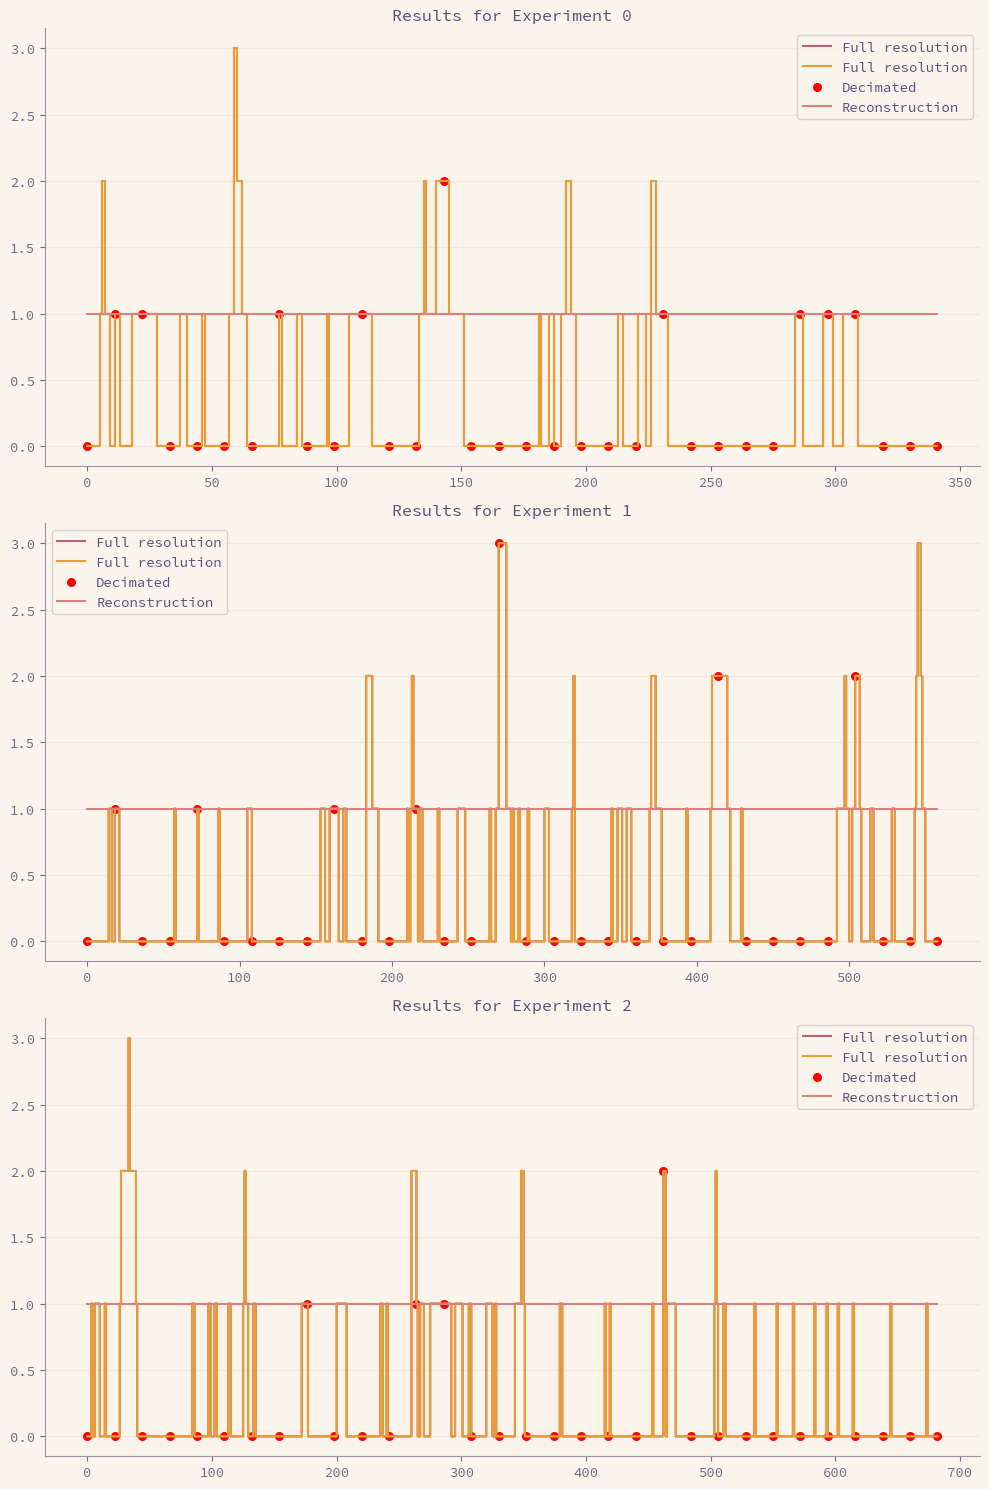

In [ ]:
def hard_decimation_of_state(high_freq_signal: torch.Tensor, rate: int, sampling_budget:int, num_classes:int):
    blank_slate = torch.zeros_like(high_freq_signal)
    seq_len = len(blank_slate)
    samples = high_freq_signal[::rate][:sampling_budget]
    for i,sample in enumerate(samples):
        blank_slate[i*rate] = sample
    # turn blank_slate into one hot
    one_hot = F.one_hot(blank_slate.to(torch.long), num_classes=num_classes).view(1,-1,num_classes)
    return one_hot

sampling_agent.eval()
reconstructor.eval()

# Visually confirm proper reconstruction. 
num_examples = 3

fig, axs = plt.subplots(num_examples,1, figsize=(10,15))
# Start with some previous state. 

states = [env.reset(current_decimation_factor).view(1, -1).to(device)]

for ne in range(num_examples):
    cur_state = states[-1]
    # Maybe do argmax instead of sampling
    action_probs = sampling_agent(cur_state[:sampling_budget])
    dist = torch.distributions.Categorical(action_probs)
    sampled_action = dist.sample() + 1 # So as to not sample 0 (and end up dividing by zero)

    new_state = torch.Tensor(
        state_generator.sample(sampled_action, sampling_budget)
    ).to(device)

    new_state_oh = F.one_hot(
        new_state.view(1, -1).to(torch.long),
        num_classes=state_generator.max_state + 1,
    ).float()

    dec_state = hard_decimation_of_state(new_state, sampled_action, sampling_budget, num_states)

    reconstruction_probs = F.softmax(reconstructor(
        dec_state,
        sampled_action,
    ),dim=-1)
    reconstruction_states = torch.argmax(reconstruction_probs,dim=-1).cpu().detach().numpy().squeeze()

    states.append(new_state)
    new_state = new_state.cpu().detach().numpy()
    sampled_action = sampled_action.cpu().detach().numpy()

    # Do plotting here
    axs[ne].plot(np.arange(len(new_state)), new_state, new_state,drawstyle="steps-post",label="Full resolution")#, marker="^",markersize=3)
    # Plot Samples
    dec_x = np.arange(sampling_budget)*(int(sampled_action))
    axs[ne].scatter(dec_x, new_state[::int(sampled_action)][:sampling_budget], label="Decimated", marker="o",color='r',s=30)
    axs[ne].set_title(f"Results for Experiment {ne}")

    # Plot Reconstrunction
    axs[ne].plot(np.arange(len(reconstruction_states)), reconstruction_states, label="Reconstruction")#, marker="x",markersize=3)
    axs[ne].legend()
plt.tight_layout()
plt.show()
    
